In [203]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import numpy as np

# Load the YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [204]:
def extract_yamnet_embedding(audio_path):
    y, sr = librosa.load(audio_path, sr=16000, mono=True)
    waveform = tf.convert_to_tensor(y, dtype=tf.float32)

    scores, embeddings, spectrogram = yamnet_model(waveform)
    # Use mean of embeddings across time as feature
    embedding_mean = tf.reduce_mean(embeddings, axis=0).numpy()
    return embedding_mean

In [403]:
audios = [
    # 'output_audios/audio1.wav',
    # 'output_audios/audio2.wav',
    'output_audios/audio3.wav',
    'output_audios/audio4.wav',
    'output_audios/audio6.wav',
    'output_audios/audio7.wav',
    'output_audios/audio8.wav',
    'output_audios/audio9.wav',
    'output_audios/audio10.wav',
    'output_audios/audio11.wav',
    'output_audios/audio12.wav',
    'output_audios/audio13.wav',
    'output_audios/audio14.wav',
    'output_audios/audio15.wav',
    'output_audios/audio16.wav',
    'output_audios/audio17.wav',
    'output_audios/9 Apr, 3.21 pm.wav',
    'output_audios/New recording 21.wav',
]
X = [extract_yamnet_embedding(audio) for audio in audios]

In [404]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [405]:
X = np.array(X)  # your list of 1024-dim embeddings

# # Scale features (important for DBSCAN with Euclidean distance)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X.shape

(16, 1024)

In [406]:
# --- Step 1: Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.2638702 , -0.9335068 ,  3.103804  , ...,  3.3775249 ,
        -0.25904542, -0.2581989 ],
       [-0.2638702 , -1.219437  ,  0.07081661, ...,  1.6628772 ,
        -0.25904542, -0.2581989 ],
       [ 3.872787  , -0.488246  , -0.62526435, ..., -0.32244578,
         3.872965  ,  3.8729832 ],
       ...,
       [-0.2638702 ,  2.0514538 ,  0.4599064 , ..., -0.37630442,
        -0.25904542, -0.2581989 ],
       [-0.25189987, -1.2958845 , -0.58759177, ..., -0.35592327,
        -0.25904542, -0.2581989 ],
       [-0.23315352, -1.2958845 , -0.4376564 , ..., -0.37630442,
        -0.25904542, -0.2581989 ]], dtype=float32)

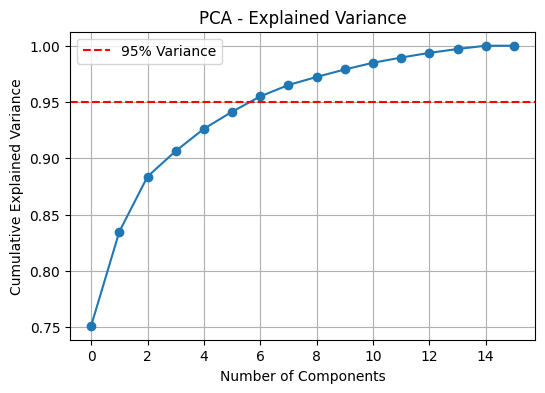

📉 Number of components to retain 95% variance: 7


In [407]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X_scaled is your scaled (standardized) 1024-dim embeddings
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Get number of components to retain 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"📉 Number of components to retain 95% variance: {n_components_95}")


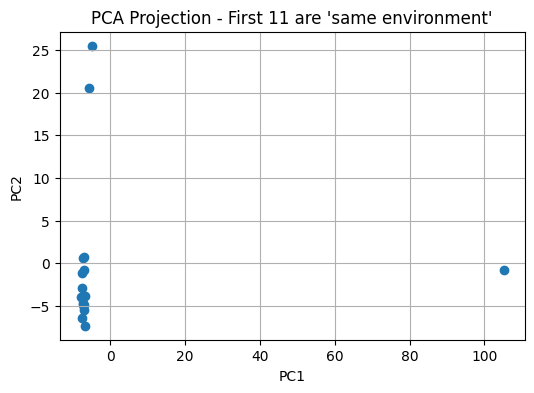

In [408]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

# Visualize: color first 11 as one group

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title("PCA Projection - First 11 are 'same environment'")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [409]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(X_pca)
# print("Pairwise distances:\n", dists)

[[ 0  1]
 [ 1  0]
 [ 2  9]
 [ 3 11]
 [ 4  7]
 [ 5  8]
 [ 6 12]
 [ 7 13]
 [ 8  5]
 [ 9 10]
 [10  9]
 [11  3]
 [12  6]
 [13 12]
 [14 15]
 [15 14]]
[  3.49894958   3.49894958   5.44085694   5.44085694   5.61111312
   6.11157499   6.11157499   6.47945521   6.47945521   6.82998292
   7.57200313   7.57200313   9.77215827  25.77192578  25.77192578
 112.42140682]
🔍 Chosen eps: 9.772158267358044


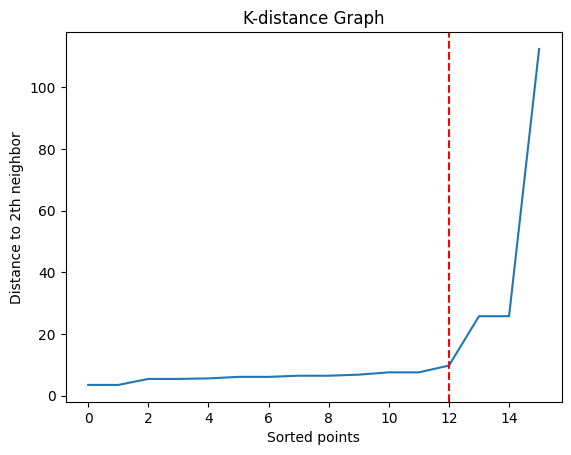

In [412]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

# Let's say X_2d is your data after PCA (shape: [n_samples, n_components])
k = 2  # min_samples for DBSCAN (or set to any expected density threshold)

# Step 1: Fit Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)

# Step 2: Calculate distances to the k-th nearest neighbor
distances, indices = neighbors_fit.kneighbors(X_pca)
print(indices)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
print(distances)
# Step 3: Find elbow point (i.e. best eps)
kneedle = KneeLocator(
    range(len(distances)),
    distances,
    curve="convex",
    direction="increasing"
)

# Step 4: This is your automated eps
epsilon = distances[kneedle.elbow]
print("🔍 Chosen eps:", epsilon)

# Optional: Plot the knee
plt.plot(distances)
plt.axvline(x=kneedle.elbow, color='red', linestyle='--')
plt.title("K-distance Graph")
plt.xlabel("Sorted points")
plt.ylabel("Distance to {}th neighbor".format(k))
plt.show()

In [419]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=12, min_samples=2)
labels = clusterer.fit_predict(X_pca)
labels

array([-1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1])

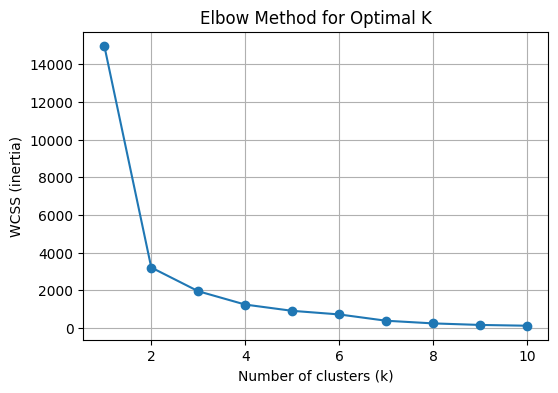

In [420]:

from sklearn.cluster import KMeans

# Step 2: Run KMeans for multiple values of k and store WCSS
wcss = []
K_range = range(1, 11)  # Try 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Step 3: Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (inertia)')
plt.grid(True)
plt.show()

In [422]:
# Step 4: Detect "elbow" using KneeLocator
kneedle = KneeLocator(K_range, wcss, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow or 3  # fallback to 3 if None
print(f"📌 Optimal number of clusters: {optimal_k}")

# Step 5: Apply KMeans with optimal_k
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)
labels

📌 Optimal number of clusters: 2


array([2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3], dtype=int32)